**Important**:
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.

1. Submit in **teams of 3 or 4 students**, add their names and matriculation numbers below. Only **one team member should upload** the solutions.
2. **Use jupyter notebook**. Other notebook-editing software (e.g. jupyter-lab, pycharm) might corrupt the notebook files and could have issues with displaying matplotlib interactively.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

# 3D Reconstruction

This exercise will guide you through two common operations we can apply to point correspondences extracted from stereo image pairs:

1. Estimation of the **fundamental matrix** (relating points in one image to lines in the other), and
2. **Triangulation** of 3D scene points given their projected image coordinates and the camera matrices.

We will use pre-computed point correspondences (loaded from file), which were estimated using a method similar to Exercise 3.

In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-number) ". ";}
</style>

In [2]:
%matplotlib inline
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import cv2
import os
from scipy import signal
from attrdict import AttrDict

def load_data(d_name):
    """ Load images and matches.
    
    Args:
        d_name: Should be 'house' or 'library'
        
    Returns:
        img0, img1: Images
        x0, x1: 3xN matrix of matching points
        P0, P1: 3X4 camera matrix
    """
    img0 = imageio.imread(f'{d_name}1.jpg')
    img1 = imageio.imread(f'{d_name}2.jpg')
    x0 = np.genfromtxt(f'{d_name}_matches_x1.csv', delimiter=',', dtype=np.float64)
    x1 = np.genfromtxt(f'{d_name}_matches_x2.csv', delimiter=',', dtype=np.float64)
    P0 = np.loadtxt(f'{d_name}1_camera.txt')
    P1 = np.loadtxt(f'{d_name}2_camera.txt')
    return img0, img1, x0, x1, P0, P1

def plot_multiple(images, titles=None, colormap='gray', 
                  max_columns=np.inf, imwidth=4, imheight=4, share_axes=False):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [''] *len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()
    
def draw_keypoints(img, x):
    img = img.copy()
    for p, color in zip(x.T, colors):
        cv2.circle(img, (int(p[0]), int(p[1])), thickness=2, radius=1, color=color)
    return img
    
def draw_point_matches(img0, img1, x0, x1, color_mask=None):
    result = np.concatenate([img0, img1], axis=1)
    img0_width = img0.shape[1]
    
    if color_mask is None:
        color_mask = np.ones(x0.shape[1], dtype=bool)
        
    for p0, p1, c_flag in zip(x0.T, x1.T, color_mask):
        p0x, p0y = int(p0[0]), int(p0[1])
        p1x, p1y = int(img0_width + p1[0]), int(p1[1])
        color = (0, 255, 0) if c_flag else (255, 0, 0)
        cv2.line(result, (p0x, p0y), (p1x, p1y),
                 color=color, thickness=1, lineType=cv2.LINE_AA)
    return result

def random_colors(n_colors):
    """Create a color map for visualizing the labels themselves,
    such that the segment boundaries become more visible, unlike
    in the visualization using the cluster peak colors.
    """
    import matplotlib.colors
    rng = np.random.RandomState(2)
    values = np.linspace(0, 1, n_colors)
    colors = plt.cm.get_cmap('hsv')(values)
    rng.shuffle(colors)
    return colors*255

colors = random_colors(1000)

def draw_line(img, l):
    if abs(l[0]) < abs(l[1]):
        # More horizontal
        slope = -l[0] / l[1]
        intercept = -l[2] / l[1]
        xs = np.array([0, img.shape[1]])
        ys = intercept + slope * xs
        cv2.line(img, (int(xs[0]), int(ys[0])), (int(xs[1]), int(ys[1])),
                 color=(0, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    else:
        # More vertical
        slope = -l[1] / l[0]
        intercept = -l[2] / l[0]
        ys = np.array([0, img.shape[0]])
        xs = intercept + slope * ys
        cv2.line(img, (int(xs[0]), int(ys[0])), (int(xs[1]), int(ys[1])),
                 color=(0, 255, 255), thickness=1, lineType=cv2.LINE_AA)

def draw_points_and_epipolar_lines(img, points, lines):
    """
    Args:
        img: First or second image
        x: 3xN matrix of points (on the same image)
        l: 3xN matrix of lines (on the same image)
    """
    points = points[:2] / points[2]  # Normalize
    img = img.copy()
    
    for l in lines.T:
        draw_line(img, l)

    for (x,y), color in zip(points.T, colors):
        cv2.circle(img, (int(x), int(y)), thickness=2, radius=1, color=color)

    return img

## Fundamental Matrix Estimation

In this exercise, we will use the eight-point algorithm presented in the lecture in order to estimate the fundamental matrix between a pair of images. The overall workflow will be very similar to how we estimated the homography matrix in Exercise 3. The main difference is that a homography can only be used either when the scene is planar (with unrestricted camera transformation between the images) *or* when the camera is purely rotated but not translated (for unrestricted scene structure). If none of these conditions hold (non-planar scene with camera translation), we need to use the more general model represented by the fundamental matrix.


We will use a slightly simpler version of the algorithm here than the one presented in the lecture. Let's first assume that we are given a list of perfect correspondences $x = (u,v,1)^T$ and
$x′ = (u′, v′, 1)^T$ (in the code, we use `x0` for $x'$ and `x1` for $x$), so that we don’t have to deal with outliers. The fundamental matrix constraint states that each such correspondence must fulfill the equation

$$
x'^T\mathrm{F}x = 0
$$

We can reorder the entries of the matrix to transform this into the following equation

$$
[\begin{matrix}{u'u} & {u'v} & u' & {v'u} & {v'v} & v' & u & v & 1\end{matrix}] \left[\begin{matrix}F_{11} \cr F_{12} \cr F_{13} \cr F_{21} \cr F_{22} \cr F_{23} \cr F_{31} \cr F_{32} \cr F_{33}\end{matrix}\right] = 0
$$

By stacking $N ≥ 8$ of those equations in a matrix $\mathrm{A}$, we obtain the matrix equation

$$
\mathrm{Af} = 0 \tag{3}
$$

$$
\left[\begin{matrix}{u_1'u_1} & {u_1'v_1} & u_1' & {v_1'u_1} & {v_1'v_1} & v_1' & u_1 & v_1 & 1 \cr {u_2'u_2} & {u_2'v_2} & u_2' & {v_2'u_2} & {v_2'v_2} & v_2' & u_2 & v_2 & 1 \cr . & . & . & . & . & . & . & . & . \cr . & . & . & . & . & . & . & . & . \cr . & . & . & . & . & . & . & . & . \cr {u_N'u_N} & {u_N'v_N} & u_N' & {v_N'u_N} & {v_N'v_N} & v_N' & u_N & v_N & 1\end{matrix}\right] \left[\begin{matrix}F_{11} \cr F_{12} \cr . \cr . \cr. \cr F_{33}\end{matrix}\right] = \left[\begin{matrix}0 \cr 0 \cr . \cr . \cr . \cr 0\end{matrix}\right] \tag{4}
$$

which can be easily solved by Singular Value Decomposition (SVD), as shown in Exercise 3. Applying SVD to $\mathrm{A}$ yields the decomposition $\mathrm{A = UDV}^⊤$. The homogeneous least-squares solution corresponds to the least singular vector, which is given by the last column of $\mathrm{V}$.

In the presence of noise, the matrix $\mathrm{F}$ estimated this way will, however, not satisfy the rank-2 constraint. This means that there will be no real epipoles through which all epipolar lines pass, but the intersection will be spread out over a small region. In order to enforce the rank-2 constraint, we therefore apply SVD to $\mathrm{F}$ and set the smallest singular value $D_{33}$ to zero.

The reconstructed matrix will now satisfy the rank-2 constraint, and we can obtain the epipoles as

$$
\mathrm{Fe_1} = 0
$$

$$
\mathrm{F^T e_0} = 0
$$

by setting $\mathrm{e_1} = \frac{[V_{13}, V_{23}, V_{33}]}{V_{33}}$ and $\mathrm{e_0} = \frac{[U_{13}, U_{23}, U_{33}]}{U_{33}}$.
  
Similarly, for the points $\mathrm{x,x′}$, we can obtain the epipolar lines $\mathrm{l′ = Fx}, \mathrm{l = F^⊤x′}$ in the other image. Note that in projective geometry, a line is also defined by a single 3D vector. This can be easily seen by starting with the standard Euclidean formula for a line

$$
ax + by + c = 0
$$

and using the fact that the equation is unaffected by scaling to apply it to the homogeneous point $\mathrm{x = (X,Y,W)}$. Thus, we arrive at

$$
aX + bY + cW = 0
$$

$$
\mathrm{l}^Tx = x^T\mathrm{l} = 0
$$

The parameters of the line are easily interpreted: $−a/b$ is the slope, $−c/a$ is the $x$-intercept, and $−c/b$ is the $y$-intercept.

If you are not familiar with homogenuous coordinates or perspective geometry, have a look at following tutorials:
http://www.maths.lth.se/matematiklth/personal/calle/datorseende13/notes/forelas2.pdf  
https://www.cse.unr.edu/~bebis/CS791E/Notes/EpipolarGeonetry.pdf  
http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/BEARDSLEY/node2.html

Write a function that implements the above algorithm to compute the fundamental matrix and the epipoles from a set of (at least 8) perfect correspondences given in the vectors x1 and x2.

In [3]:
# POINTS: 5

def get_fundamental_matrix(x0, x1):
    """
    Args:
        x0, x1: 3xN arrays of N homogenous points in 2D
        
    Returns:
        F: The 3x3 fundamental martix such that x0.T @ F @ x1 = 0
        e0: The epipole in image 0 such that F.T  @ e0 = 0
        e1: The epipole in image 1 such that F @ e1 = 0 
    """
    # YOUR CODE HERE
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    
    n_pts = x0.shape[1]
    A = np.column_stack(
        (x0[0]*x1[0], x0[0]*x1[1], x0[0], x1[0]*x0[1],
         x0[1]*x1[1], x0[1], x1[0], x1[1], np.ones(n_pts)))
    
    U, S, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
                       
    U, S, Vt = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ Vt 
    
    # Epipoles
    e0 = U[:, -1] / U[-1, -1]
    e1 = Vt[-1, :] / Vt[-1, -1]
    
    return F, e0, e1

In order to get a quantitative estimate for the accuracy of your results, write a function `get_residual_distance` that computes the distance between points in one image and their corresponding epipolar lines (distance is positive). *Hint*: Be sure to normalize both homogeneous points (divide $(wx, wy, w)^T$ by $w$) and lines (divide $(a, b, d)^T$ by $\sqrt{a^2 + b^2}$) before computing the distance. 

In [4]:
# POINTS: 5

def get_residual_distance(F, x0, x1):
    # YOUR CODE HERE
    
    # Epipolar lines
    l0 = F @ x1
    l1 = F.T @ x0
    
    # Normalization
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    l0 = l0 / np.hypot(l0[0], l0[1])
    l1 = l1 / np.hypot(l1[0], l1[1])
    
    # Residual distance 
    d0 = np.abs(np.sum(l0 * x0, axis=0))
    d1 = np.abs(np.sum(l1 * x1, axis=0))
    
    return d0, d1

In [5]:
def get_residual_error(F, x0, x1):
    d0, d1 = get_residual_distance(F, x0, x1)
    return 0.5 * (np.mean(d0) + np.mean(d1))

The estimated fundamental matrix F is 
[[ 7.40849508e-06 -6.36439582e-05  1.12134428e-02]
 [ 8.14170725e-05  1.29330911e-05 -1.29389139e-02]
 [-1.70471371e-02  6.23489699e-03  9.99688628e-01]]
Epipole 0: [137.96239621 196.82657259   1.        ], epipole 1: [128.55645851 191.15487282   1.        ]
Fitting error: 1.6 px


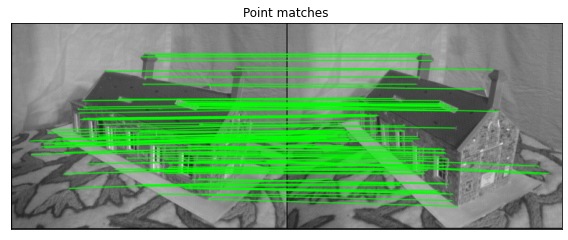

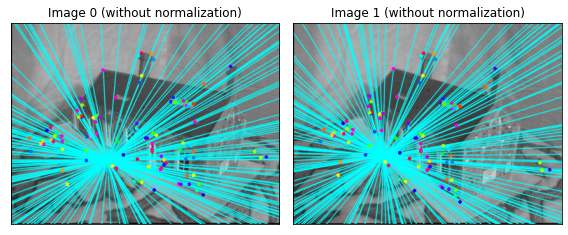

In [6]:
# NOTE: throughout this exercise, you can replace 'house'
# with 'library' to try the algorithms on another stereo pair

img0, img1, x0, x1, _, _ = load_data('house')
n_matches = 100
x0 = x0[:,:n_matches]
x1 = x1[:,:n_matches]    

F, e0, e1 = get_fundamental_matrix(x0, x1)
residual_error = get_residual_error(F, x0, x1)

print(f'The estimated fundamental matrix F is \n{F}')

plot_multiple([draw_point_matches(img0, img1, x0, x1)], 
              ['Point matches'], imwidth=8)
img0_result = draw_points_and_epipolar_lines(img0, x0, F @ x1)
img1_result = draw_points_and_epipolar_lines(img1, x1, F.T @ x0)
plot_multiple([img0_result, img1_result], 
              ['Image 0 (without normalization)', 'Image 1 (without normalization)'])

print(f'Epipole 0: {e0}, epipole 1: {e1}')
print(f'Fitting error: {residual_error:.1f} px')

How do you interprete the visualization? Is the estimated matrix good? Why or why not?

## Normalization
As explained in the lecture, we need to take care of normalizing the points in order to make sure the estimation problem is well conditioned. Write a function `normalize_points` that normalizes the given list of 2D points (in homogenuous coordinates) `x` by first shifting their origin to the centroid and then scaling them such that their mean distance from the origin is $\sqrt{2}$. Since the input points are homogeneous, pay attention to divide them by their last component before processing them. The function should return both the transformed points and the $3 × 3$ transformation matrix $\mathrm{T}$.

In [7]:
# POINTS: 5

def normalize_points(x):
    """
    Args:
        x: 3xN arrays of N homogenous points in 2D
        
    Return:
        x_trans: 3xN matrix of transformed points
        T: the 3x3 transformation matrix, points_trans = T * points
    """
    # YOUR CODE HERE

    x = x / x[2]
    center = np.mean(x, axis=1)
    T_center = np.array([[1, 0, -center[0]], [0, 1, -center[1]], [0, 0, 1]])
    x_trans = T_center @ x

    scale = np.sqrt(2) / np.mean(np.linalg.norm(x_trans[:2], axis=0))
    T_scale = np.array([[scale, 0, 0],
                        [0, scale, 0],
                        [0, 0, 1]])
    T = T_scale @ T_center
    x_trans = T @ x
    
    return x_trans, T

Now write an adapted function `get_fundamental_matrix_with_normalization` that first normalizes the input points, computes the fundamental matrix based on the normalized points, and then undoes the transformation by applying $\mathrm{F = T_0^⊤FT_1}$ before computing the epipoles.

In [8]:
# POINTS: 5

def get_fundamental_matrix_with_normalization(x0, x1):
    """
    Args:
        x0, x1: 3xN arrays of N homogenous points in 2D
        
    Returns:
        F: The 3x3 fundamental martix such that x0'*F*x1 = 0
        e0: The epipole in image 0 such that F'*e0 = 0
        e1: The epipole in image 1 such that F*e1 = 0 
    """
    # YOUR CODE HERE
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    
    x0_norm, T0 = normalize_points(x0)
    x1_norm, T1 = normalize_points(x1)
    F_norm, _, _ = get_fundamental_matrix(x0_norm, x1_norm)

    F = T0.T @ F_norm @ T1
    
    # Epipoles
    U, _, Vt = np.linalg.svd(F)
    e0 = U[:, -1] / U[-1, -1]
    e1 = Vt[-1, :] / Vt[-1, -1]
    return F, e0, e1

The estimated fundamental matrix F is 
[[ 5.51753355e-09  4.96874507e-06 -7.28741175e-06]
 [ 1.53686603e-06 -2.53781411e-07  1.22196065e-02]
 [-1.70946239e-05 -1.34047209e-02  2.09706039e-03]]
Epipole 0: [2.69788155e+03 1.43732234e+00 1.00000000e+00], epipole 1: [-7.94929021e+03  1.02939246e+01  1.00000000e+00]
Fitting error: 0.2 px


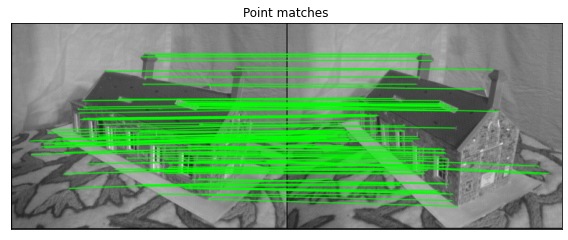

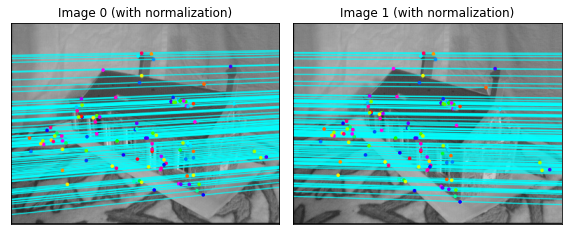

In [9]:
img0, img1, x0, x1, _, _ = load_data('house')

n_matches = 100
x0 = x0[:,:n_matches]
x1 = x1[:,:n_matches]

F, e0, e1 = get_fundamental_matrix_with_normalization(x0, x1)
residual_error = get_residual_error(F, x0, x1)
print(f'The estimated fundamental matrix F is \n{F}')

plot_multiple([draw_point_matches(img0, img1, x0, x1)], 
              ['Point matches'], imwidth=8)
img0_result = draw_points_and_epipolar_lines(img0, x0, F @ x1)
img1_result = draw_points_and_epipolar_lines(img1, x1, F.T @ x0)
plot_multiple([img0_result, img1_result], 
              ['Image 0 (with normalization)', 'Image 1 (with normalization)'])

print(f'Epipole 0: {e0}, epipole 1: {e1}')
print(f'Fitting error: {residual_error:.1f} px')

How can you visually verify the results? That is, what exactly do you need to look at in the result images to decide whether the algorithm worked well? Did the normalization help?

## Selecting correspondences (optional)
Have a look at the provided script `label_matches.py`, which allows you to label your own correspondences. Test the implemented eight-point algorithm with your labeled data.

## RANSAC
In practice, the correspondence set will always contain noise and outliers. We therefore apply RANSAC in order to get a robust estimate. It proceeds along the following steps:

1. Randomly select a (minimal) seed group of point correspondences on which to base the estimate.
2. Compute the fundamental matrix from this seed group.
3. Find inliers to this transformation.
4. If the number of inliers is sufficiently large $(≥ m)$, recompute the least-squares estimate of the fundamental matrix on all inliers.
5. Else, repeat for a maximum of k iterations.

The parameter $k$ can be chosen automatically. Suppose $w$ is the fraction of inlier correspondences and $n = 8$ correspondences are needed to define a hypothesis. Then the probability that a single sample of $n$ correspondences is correct is $w^n$, and the probability that all samples fail is $(1 − w^n)^k$. The standard strategy is thus, given an estimate for $w$, to choose $k$ high enough that this value is kept below our desired failure rate.

In the following, we will implement the different steps of the RANSAC procedure and apply it for robust estimation of the fundamental matrix.

First write a function which takes as input an estimated fundamental matrix and the full set of correspondence candidates and which returns: *(1)* the ratio, and *(2)* the indices of the inliers. A point pair $x, x′$ is defined to be an inlier if the distance of $x$ to the epipolar line $\mathrm{l = F^⊤x′}$, as well as the opposite distance, are both less than some threshold $ε$.

In [10]:
# POINTS: 3

def get_inliers(F, x0, x1, eps):
    # YOUR CODE HERE
    d0, d1 = get_residual_distance(F, x0, x1)
    indices = np.argwhere(np.logical_and(d0 < eps, d1 < eps))[...,0]
    return indices

Now write a function which implements the RANSAC procedure to estimate a fundamental matrix using the normalized eight-point algorithm. For randomly sampling matches, you can use the `np.random.choice()` function. Here, we want to use a simple version of the algorithm that just runs for a fixed number of `n_iter` iterations and returns the solution with the largest inlier set.

In [11]:
# POINTS: 7

def get_fundamental_matrix_with_ransac(x0, x1, eps=10, n_iter=1000):
    """
    Args:
        x0, x1: 3xN arrays of N homogenoous points in 2D
        eps: Inlier threshold
        n_iter: Number of iterations
    
    Return:
        F: The 3x3 fundamental martix such taht x2'*F*x1 = 0
        e0: The epipole in image 1 such that F'*e0 = 0
        e1: The epipole in image 2 such that F*e1 = 0 
        inlier_ratio: Ratio of inlier
        inlier_indices: Indices of inlier
    """
    # YOUR CODE HERE
    n_pts = x1.shape[1]
    n_sample = 8
    
    indices = np.arange(n_pts)
    best_inlier_indices = []

    for i in range(n_iter):
        sample_ind = np.random.choice(indices, size=n_sample, replace=False)
        x0_sample = x0[:, sample_ind]
        x1_sample = x1[:, sample_ind]

        F, e0, e1 = get_fundamental_matrix_with_normalization(x0_sample, x1_sample)

        # Inliers
        inlier_indices = get_inliers(F, x0, x1, eps)        
        if len(inlier_indices) > len(best_inlier_indices):
            best_inlier_indices = inlier_indices
            
            
    # Fundamental matrix w/ inliers
    F, e0, e1 = get_fundamental_matrix_with_normalization(
            x0[:, best_inlier_indices], x1[:, best_inlier_indices])
    
    return F, e0, e1, best_inlier_indices

Since we are working with precomputed ground-truth point correspondences loaded from file (and not estimated ones as we did in Exercise 3), we will artificially create outlier pairs using the following function. This is to simulate the effect of noisy point correspondence estimation.

In [12]:
def inject_outliers(img, x0, x1, outlier_ratio):
    """Artifically create outliers.
    
    Args:
        img: Image, used only for size
        x0, x1: Input 3xN points 
        outlier_ratio: Probability (ratio) of outlier
        
    Returns:
        x0_noisy, x1_noisy: Output points (with outlier)
        inlier_mask: 1D binary array
    """
    n_pts = x0.shape[1]
    h, w = img.shape[:2]
    
    outlier_mask = np.random.uniform(size=n_pts) < outlier_ratio
    n_outliers = sum(outlier_mask)
    outlier_x01 = np.random.randint(low=0, high=w, size=(2, n_outliers))
    outlier_y01 = np.random.randint(low=0, high=h, size=(2, n_outliers))
    
    x0_noisy, x1_noisy = x0.copy(), x1.copy()
    x0_noisy[0, outlier_mask] = np.random.randint(low=0, high=w, size=n_outliers)
    x0_noisy[1, outlier_mask] = np.random.randint(low=0, high=h, size=n_outliers)
    x1_noisy[0, outlier_mask] = np.random.randint(low=0, high=w, size=n_outliers)
    x1_noisy[1, outlier_mask] = np.random.randint(low=0, high=h, size=n_outliers)

    return x0_noisy, x1_noisy, np.invert(outlier_mask)

-------- Without RANSAC --------
The estimated fundamental matrix F is 
[[-7.37774013e-06 -2.71219601e-05  9.22639925e-03]
 [-1.93504509e-05 -1.01328619e-04  2.87974621e-02]
 [ 3.35882824e-03  1.31318087e-02 -4.31987970e+00]]
Epipole 0: [387.14897888  25.97064453   1.        ], epipole 1: [690.69302519 152.29893342   1.        ]
Fitting error: 54.5 px
-------- With RANSAC --------
The estimated fundamental matrix F is 
[[ 6.37999097e-07 -8.36983004e-06  9.46405401e-04]
 [ 3.00303611e-06  8.38583631e-07 -1.35055310e-02]
 [-1.47648229e-03  1.42651668e-02  8.84052747e-02]]
Epipole 0: [1.71706687e+03 1.26869994e+02 1.00000000e+00], epipole 1: [4.37264199e+03 4.46382665e+02 1.00000000e+00]
Fitting error: 0.3 px
Inlier ratio: 66% (groundtruth: 67%)


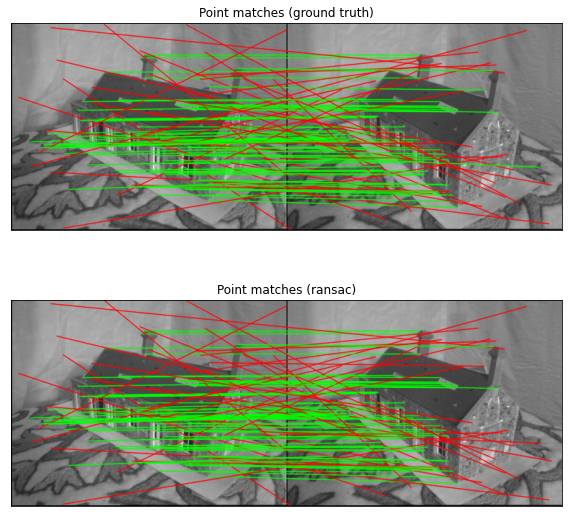

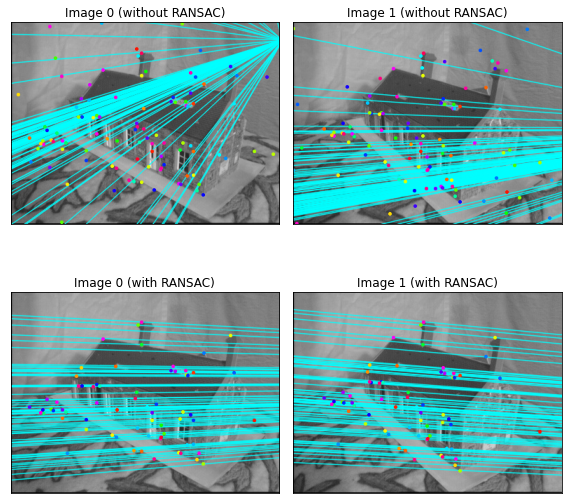

In [13]:
img0, img1, x0, x1, _, _ = load_data('house')
n_matches = 100
x0 = x0[:, :n_matches]
x1 = x1[:, :n_matches]
x0, x1, inlier_mask = inject_outliers(img0, x0, x1, outlier_ratio=0.3)
x0_inlier, x1_inlier = x0[:, inlier_mask], x1[:, inlier_mask]
inlier_ratio = sum(inlier_mask) / x0.shape[1]

# Without RANSAC
F_vanilla, e0_vanilla, e1_vanilla = get_fundamental_matrix_with_normalization(x0, x1)
residual_error_vanilla = get_residual_error(F_vanilla, x0_inlier, x1_inlier)
print('-------- Without RANSAC --------')
print(f'The estimated fundamental matrix F is \n{F_vanilla}')
print(f'Epipole 0: {e0_vanilla}, epipole 1: {e1_vanilla}')
print(f'Fitting error: {residual_error_vanilla:.1f} px')

# With RANSAC
eps = 1
n_iter = 1000
F_ransac, e0_ransac, e1_ransac, inlier_indices = get_fundamental_matrix_with_ransac(
    x0, x1, eps, n_iter)
residual_error_ransac = get_residual_error(F_ransac, x0_inlier, x1_inlier)
inlier_ratio_ransac = len(inlier_indices) / x0.shape[1]
inlier_mask_ransac = np.zeros(x0.shape[1], dtype=bool)
inlier_mask_ransac[inlier_indices] = True
print('-------- With RANSAC --------')
print(f'The estimated fundamental matrix F is \n{F_ransac}')
print(f'Epipole 0: {e0_ransac}, epipole 1: {e1_ransac}')
print(f'Fitting error: {residual_error_ransac:.1f} px')
print(f'Inlier ratio: {inlier_ratio_ransac:.0%} (groundtruth: {inlier_ratio:.0%})')

# Plotting
plot_multiple([draw_point_matches(img0, img1, x0, x1, inlier_mask),
              draw_point_matches(img0, img1, x0, x1, inlier_mask_ransac)], 
              ['Point matches (ground truth)',
              'Point matches (ransac)'], imwidth=8, max_columns=1)

img0_vanilla = draw_points_and_epipolar_lines(img0, x0, F_vanilla @ x1)
img1_vanilla = draw_points_and_epipolar_lines(img1, x1, F_vanilla.T @ x0)
img0_ransac = draw_points_and_epipolar_lines(img0, x0_inlier, F_ransac @ x1_inlier)
img1_ransac = draw_points_and_epipolar_lines(img1, x1_inlier, F_ransac.T @ x0_inlier)
plot_multiple([img0_vanilla, img1_vanilla, img0_ransac, img1_ransac], 
              ['Image 0 (without RANSAC)', 'Image 1 (without RANSAC)',
               'Image 0 (with RANSAC)', 'Image 1 (with RANSAC)'], max_columns=2)

## Harris points [OPTIONAL, 0 pts]  
We can use a keypoint extractor and descriptor to find matches, as in Exercise 3. You can either use code from there, or use built-in functions of OpenCV (look up how to use `cv2.BRISK_create` for example -- BRISK is a non-patented alternative of SIFT).

Write a full pipeline that does the following:
1. Load a pair of images;
2. Extract and match keypoints (clearly visualize the results);
3. Estimate the fundamental matrix (clearly visualize the results).

In [14]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: ignored

## Triangulation
As a final step, we want to reconstruct the observed points in 3D by triangulation. Note that just using two images, this is not possible without a calibration. You can therefore find camera matrices for each image provided in the archive *exercise5.zip*. They are stored as simple text files containing a single $3 × 4$ matrix and can be read in with the `np.loadtxt` command.

For triangulation, we use the linear algebraic approach from the lecture. Given a 2D point correspondence $\mathrm{x_1, x_2}$ in homogeneous coordinates, the 3D point location $\mathrm{X}$ is given as follows:

$$
\lambda_1\mathrm{x_1} = \mathrm{P_1X}
$$

$$
\lambda_2\mathrm{x_2} = \mathrm{P_2X}
$$

We can now build the cross-product of each point with both sides of the equation and obtain

$$
\mathrm{x_1} \times \mathrm{P_1X} = [\mathrm{x_1}_\times]\mathrm{P_1X} = 0
$$

$$
\mathrm{x_2} \times \mathrm{P_2X} = [\mathrm{x_2}_\times]\mathrm{P_2X} = 0
$$

where we used the skew-symmetrix matrices $[\mathrm{x_i}_\times]$ to replace the cross products

$$
\mathrm{a \times b} = \mathrm{[\mathrm{a}_\times]b} = \left[\begin{matrix}0&-a_z&a_y \cr a_z&0&-a_x \cr -a_y&a_x&0\end{matrix}\right]\mathrm{b}
$$

Each 2D point provides 2 independent equations for a total of 3 unknowns. We can therefore solve the overconstrained system by stacking the first two equations for each point in a matrix $\mathrm{A}$ and computing the least-squares solution for $\mathrm{AX} = 0$.

First write a function to find the centers of both cameras. Recall from the lecture that the camera centers are given by the null space of the camera matrices. They can thus be found by taking the SVD of the camera matrix and taking the last column of $\mathrm{V}$ normalized by the 4th entry.

In [15]:
# POINTS: 3

def camera_center_from_projection_matrix(P):
    # YOUR CODE HERE
    _, _, Vt = np.linalg.svd(P)
    center = Vt[-1, :-1] / Vt[-1,-1]
    return center

In [16]:
img0, img1, x0, x1, P0, P1 = load_data('house')
C0 = camera_center_from_projection_matrix(P0)
C1 = camera_center_from_projection_matrix(P1)

print(f'P0: {P0}')
print(f'P1: {P1}')
print(f'C0: {C0}')
print(f'C1: {C1}')

P0: [[ 1.6108033e+01  1.3704159e+01 -6.7351564e+01 -1.8838024e+02]
 [ 8.2886212e-01 -6.1257005e+01 -2.7985739e+01 -7.4190016e+00]
 [ 1.6739784e-01 -4.5720139e-02 -8.4811075e-02  5.6548906e-01]]
P1: [[ 1.0571624e+01  4.0812730e+00 -2.2538413e+01 -5.9593366e+01]
 [ 3.1827253e-01 -2.1616617e+01 -9.8820962e+00 -2.7146868e+00]
 [ 6.1142503e-02 -2.0656640e-02 -2.0701037e-02  2.5211789e-01]]
C0: [-4.82245697  1.48072657 -3.64903811]
C1: [-5.04951907  1.93166599 -4.66276516]


Now write a function *triangulate* that uses linear least-square method to triangulate the position of a matching point pair in 3D, as described above. A well suited helper function is *vector_to_skew(v)* which returns a skew symmetric matrix from the vector v with 3 elements.

In [17]:
def vector_to_skew(vec):
    return np.array([[0,      -vec[2], vec[1]],
                     [ vec[2], 0,     -vec[0]],
                     [-vec[1], vec[0], 0]])

In [18]:
# POINTS: 7

def triangulate(x0, x1, P0, P1):
    """ Triangulate matching points.
    Args:
        x0, x1: 3xN matrices of matching points (homogeneous)
        P0, P1: 3X4 camera matrices

    Returns:
        X: 3xN matrix of points in world space
    """
    # YOUR CODE HERE
    X = np.empty((4, x0.shape[1]), dtype=np.float64)
    for i in range(x0.shape[1]):
        A = np.concatenate([vector_to_skew(x0[:, i])[:2] @ P0, 
                            vector_to_skew(x1[:, i])[:2] @ P1], axis=0)
        _, _, Vt = np.linalg.svd(A, full_matrices=False)
        X[:, i] = Vt[-1, :] / Vt[-1, -1]
    
    return X

Write a function to compute the reprojection errors (average distance) between the observed 2D points and the projected 3D points in the two images. 

In [19]:
# POINTS: 5

def get_reprojection_error(X, x, P):
    # YOUR CODE HERE
    x_p = P @ X
    res = x - x_p / x_p[2, :]
    distance = np.hypot(res[0, :], res[1, :])
    return np.mean(distance)

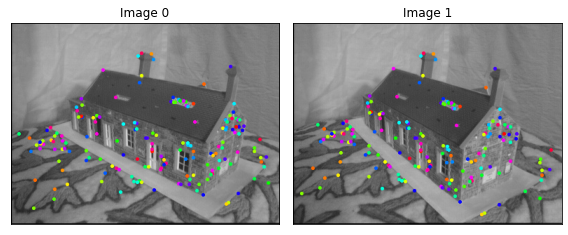

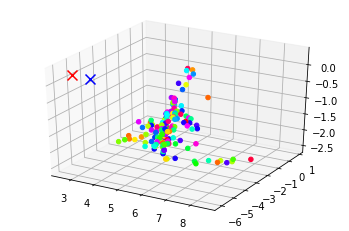

Reprojection error: 0.1 px


In [20]:
def plot_3d_reconstruction(X, C0, C1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    c = colors[:X.shape[1]]/255
    ax.scatter(X[0], X[1], X[2], c=c, alpha=1)
    ax.scatter(C0[0], C0[1], C0[2], color='red', s=100, marker='x')
    ax.scatter(C1[0], C1[1], C1[2], color='blue', s=100, marker='x')
    plt.show()

X = triangulate(x0, x1, P0, P1)
error0 = get_reprojection_error(X, x0, P0)
error1 = get_reprojection_error(X, x1, P1)
error = 0.5 * (error0 + error1)

# Rotate the visualization to be more recognizable.
U,S,Vt = np.linalg.svd(P0[:3,:3], full_matrices=False)
rot = U @ Vt
rot = np.array([[1,0,0], [0,0,1], [0,-1,0]]) @ rot

plot_multiple([draw_keypoints(img0, x0), draw_keypoints(img1, x1)], 
              ['Image 0', 'Image 1'])
plot_3d_reconstruction(rot @ X[:3]/X[3], rot @ C0, rot @ C1)
print(f'Reprojection error: {error:.1f} px')

## Reconstruction with RANSAC [OPTIONAL, 0 pts]
Reconstruction quality can be further improved by filtering out outliers using RANSAC based on fundamental matrix. Try to implement it, and clearly visualize the results.

In [21]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: ignored